In [1]:
####The foloowing code tries to recreate Fig. 1 of Turkeshi2025. Let us utilize Qiskit for now
import qiskit
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
import qiskit_aer 
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.circuit.library import Initialize
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Operator

import stim






In [2]:
##Firstly, we will write functions for creating 4^N Pauli strings for arbitrary N. We need a recursive nested function

Paulis = ['I', 'X', 'Y', 'Z']
PauliOps = []

N = 1
c = N
str1 = ''

def PauliStrings(N,c,str1):
    if c == 1:
        for i in range(len(Paulis)):
            PauliOps.append(str1 + Paulis[i])
    else:
        for i in range(len(Paulis)):
            PauliStrings(N,c-1,str1+Paulis[i])

##Testing function
PauliStrings(N,c,str1)
print(len(PauliOps) == 4**N)
print(PauliOps)


True
['I', 'X', 'Y', 'Z']


In [3]:
### Now let us create the Haar Random and product states.

def random_statevector(theta, phi):
    rand_st = np.cos(theta/2)*Statevector.from_label('0') + np.exp(1j*phi)*np.sin(theta/2)*Statevector.from_label('1')
    return rand_st

def ProductState(N,theta,phi):
    for i in range(N):
        if i == 0:
                rand_st = random_statevector(theta, phi)
        else:
                rand_st = rand_st.expand(random_statevector(theta, phi))
    return rand_st

def HaarState(N):
    coeffs = []
    for i in range(2**N):
        z = np.random.randn() + 1j * np.random.randn()
        coeffs.append(z)
    coeffs = np.array(coeffs)
    hst = Statevector(coeffs)/np.linalg.norm(coeffs)
    return hst

##testing states
print(Statevector.is_valid(HaarState(2)))
print(Statevector.is_valid(ProductState(2,np.pi,np.pi/2)))
                                          

True
True


In [4]:
### Let us create a random stabilizer state

def stim_to_qiskit_circuit(stim_circuit, N):
    """Convert a Stim circuit to a Qiskit QuantumCircuit"""
    qc = QuantumCircuit(N)
    
    for op in stim_circuit:
        gate = op.name
        targets = [t.value for t in op.targets_copy()]  # Extract integer indices

        if gate == "H":
            for target in targets:
                qc.h(target)
        elif gate == "S":
            for target in targets:
                qc.s(target)
        elif gate == "CX":
            qc.cx(targets[0], targets[1])  # Ensure proper indexing

    qc.save_statevector()

    return qc


#Tip: Make circuit C^\dag P C and then compute expectation on initial |0> state
def random_stabilizer_state(N):
    """Generate a random N-qubit stabilizer state and return its statevector as a numpy array"""
    # Generate a random Clifford circuit in Stim
    circuit = stim.Circuit()
    circuit.append("H", np.random.choice(N, size=N//2, replace=False))  # Random Hadamards
    circuit.append("S", np.random.choice(N, size=N//2, replace=False))  # Random S gates
    for _ in range(N):  # Random CNOTs
        a, b = np.random.choice(N, size=2, replace=False)
        circuit.append("CX", [a, b])

    

    # Convert to Qiskit and compute statevector
    qiskit_circuit = stim_to_qiskit_circuit(circuit, N)
    simulator = AerSimulator(method='statevector')
    transpiled_circuit = transpile(qiskit_circuit, simulator)
    result = simulator.run(transpiled_circuit).result()
    statevector = result.get_statevector()

    return statevector # Returns the random stabilizer state

# Example usage:
N = 4  # Number of qubits
stabilizer_state = random_stabilizer_state(N)
print(stabilizer_state)  # Outputs a 2^N complex numpy array


Statevector([5.000000e-01+0.j , 0.000000e+00+0.j , 0.000000e+00+0.j ,
             0.000000e+00+0.j , 3.061617e-17+0.5j, 0.000000e+00+0.j ,
             0.000000e+00+0.j , 0.000000e+00+0.j , 5.000000e-01+0.j ,
             0.000000e+00+0.j , 0.000000e+00+0.j , 0.000000e+00+0.j ,
             3.061617e-17+0.5j, 0.000000e+00+0.j , 0.000000e+00+0.j ,
             0.000000e+00+0.j ],
            dims=(2, 2, 2, 2))


In [16]:
## With all three states generated, let us create the Pauli spectrum

def PauliSpectrum(PauliOps, state):
    spec_vals = []
    for op in PauliOps:
        spec_vals.append(state.expectation_value(SparsePauliOp(op)))
    return spec_vals

##Generating PauliOps
N = 10
PauliOps = []
c = N
str1 = ''
PauliStrings(N,c,str1)



theta = 2*np.arctan(np.sqrt(2-np.sqrt(3)))
phi = 2*np.arctan(1-np.sqrt(2))

prod_state = ProductState(N,theta,phi)
haar_state = HaarState(N)
#stab_state = random_stabilizer_state(N)

prod_spec = PauliSpectrum(PauliOps,prod_state)
haar_spec = PauliSpectrum(PauliOps,haar_state)
#stab_spec = PauliSpectrum(PauliOps,stab_state)

#print(stab_spec)

/opt/anaconda3/envs/qiskitenv/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)


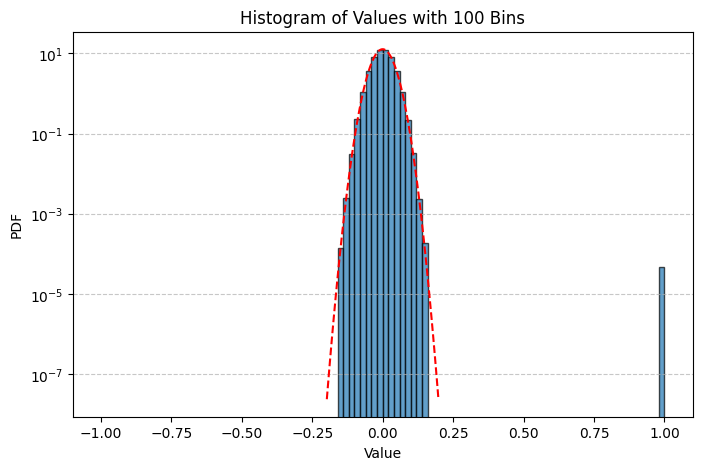

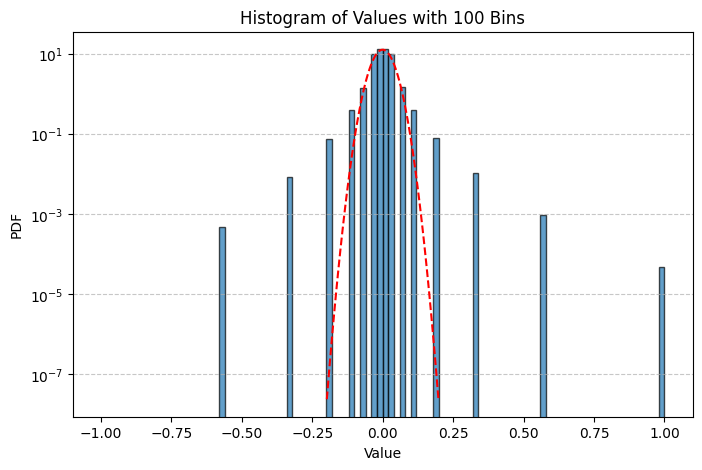

In [20]:
## Now that we have a Pauli spectrum, we need to create a distribution between - 1 and 1 of the values and plot it
def plot_histogram(data, num_bins=100):
    """
    Plots a histogram of values in `data` with `num_bins` bins.
    
    Parameters:
        data (array-like): Array of numbers between -1 and 1.
        num_bins (int): Number of bins for the histogram.
    """
    # Ensure data is within the valid range
    data = np.clip(data, -1, 1)

    # Plot histogram
    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=np.linspace(-1, 1, num_bins + 1), edgecolor='black', alpha=0.7, log=True,density=True)

    counts, bin_edges = np.histogram(data, bins=np.linspace(-0.2, 0.2, num_bins + 1),density = True)

    #counts = counts*2/(np.sum(counts)*num_bins)

    # Compute bin midpoints (alternative: use bin_edges[:-1] for start values)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    d = 2**N
    b = 1/(d+1)

    th_vals = [(d**2 - 1)*np.exp(-x**2/(2*b))/((d**2)*np.sqrt(2*np.pi*b)) for x in bin_midpoints]
    
    # Labels and title
    plt.xlabel("Value")
    plt.ylabel("PDF")
    plt.title(f"Histogram of Values with {num_bins} Bins")
    plt.plot(bin_midpoints,th_vals,'r--')
    
    # Show grid
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show plot
    plt.show()

plot_histogram(haar_spec)
plot_histogram(prod_spec)
#plot_histogram(stab_spec)

In [22]:
##Let us now calculate the filtered stabilizer entropy

d = 2**N

def FSE(q, spec):
    sum = 0
    if q == 0:
        return np.log2(d +1)
    elif q == 1:
        for i in range(1,len(spec)):
            if spec[i] == 0:
                sum+=0
            else:
                sum+=np.log2(np.abs(spec[i]))*(spec[i]**2)
        return -2*sum/(d-1)
    else:
        for i in range(1, len(spec)):
            sum += spec[i]**(2*q)
        sum/= (d-1)
        return np.log2(sum)/(1-q)

haar_fse = []
prod_fse = []
stab_fse = []

for q in range(8):
    haar_fse.append(FSE(q,haar_spec))
    prod_fse.append(FSE(q,prod_spec))
    #stab_fse.append(FSE(q,stab_spec))


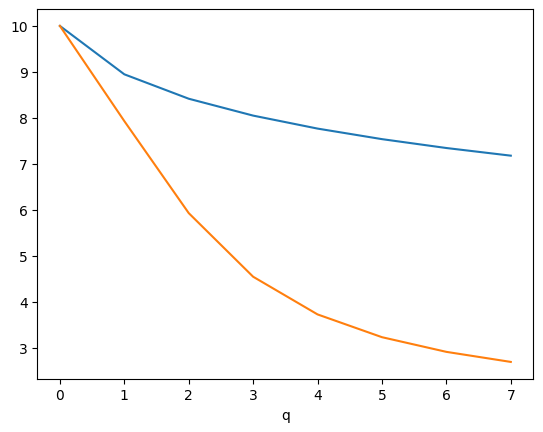

In [24]:
plt.plot(range(8),haar_fse)
plt.plot(range(8),prod_fse)
#plt.plot(range(8),stab_fse)

plt.xlabel('q')
plt.show()
